Exercice 3: GAN - Génération de données COCO
Création du dataset pour GAN...
Dataset GAN créé: TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)

Création des modèles GAN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Générateur standard paramètres: 6,197,123
Discriminateur standard paramètres: 2,768,321
Générateur attention paramètres: 6,284,563
Discriminateur attention paramètres: 2,788,961

Entraînement de démonstration - GAN Standard
(Entraînement réel nécessite plus d'époques)
Entraînement pour 5 époques (démonstration)...
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - d_loss: 0.4588 - g_loss: 0.9744

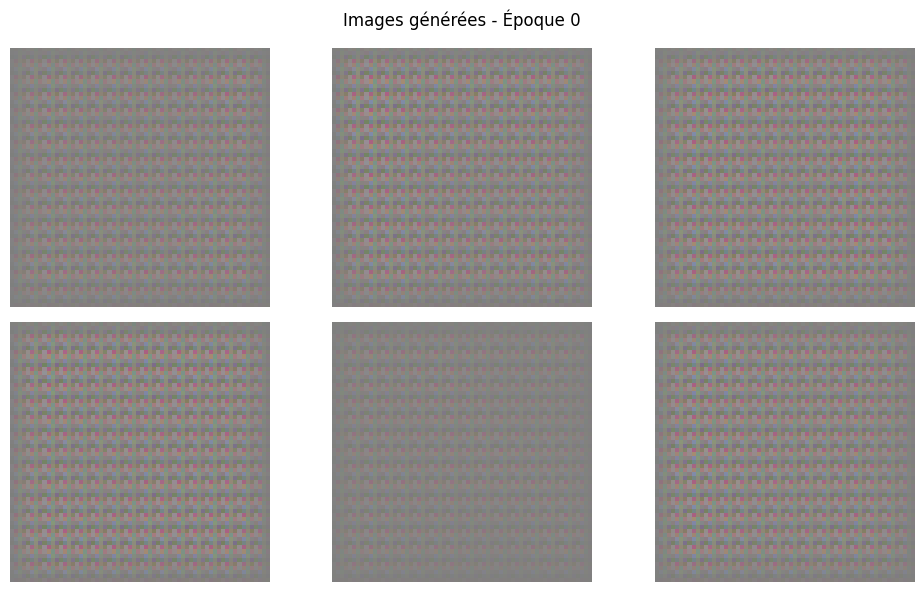

32/32 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - d_loss: 0.4541 - g_loss: 1.0054
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - d_loss: 0.2191 - g_loss: 6.6784
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - d_loss: 0.2494 - g_loss: 2.7770
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - d_loss: 0.1718 - g_loss: 3.2376
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - d_loss: 0.1776 - g_loss: 4.9098

Analyse des avantages spécifiques des modèles GAN
1. GÉNÉRATION DE DONNÉES RÉALISTES:
   ✓ Capacité à générer des images haute qualité indiscernables du réel
   ✓ Apprentissage de distributions complexes de données
   ✓ Pas besoin de modélisation explicite de la distribution

2. AUGMENTATION DE DONNÉES (DATA AUGMENTATION):
   ✓ Génération d'échantillons supplémentaires pour datasets limités
   ✓ Réduction du surapprentissage en enrichissant les données
   ✓ Création de variations réalistes pour améliorer la robustesse

3. APPRENTISSAGE NON SUPERVISÉ:
   ✓ Pas besoin d'annotations po

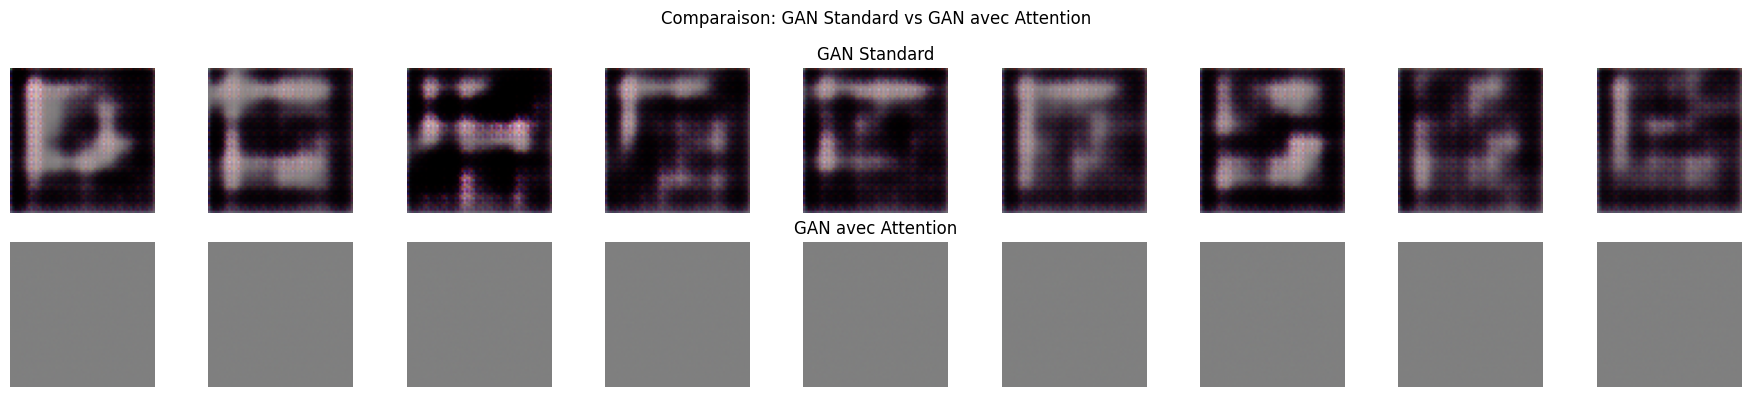


Exercice 3 terminé!
GANs standard et avec attention implémentés.
Génération de données COCO-like démontrée.
Analyse complète des avantages et implémentations réalisée.


In [1]:
# Exercice 3: GAN - Génération de données pour segmentation
# TP: Apprentissage par transfert pour la segmentation d'images - COCO Dataset

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import cv2

print("Exercice 3: GAN - Génération de données COCO")
print("=" * 50)

# Configuration
IMG_SIZE = 64  # Reduced for GAN training efficiency
LATENT_DIM = 100
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE_G = 0.0002
LEARNING_RATE_D = 0.0002

# =============================================================================
# 1. GAN Standard Implementation
# =============================================================================

def create_generator(latent_dim=100, img_size=64):
    """Générateur GAN pour images COCO"""

    model = keras.Sequential([
        # Dense layer
        layers.Dense(8 * 8 * 512, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((8, 8, 512)),

        # Upsampling blocks
        # 8x8 -> 16x16
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # 16x16 -> 32x32
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # 32x32 -> 64x64
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Final layer
        layers.Conv2D(3, (3, 3), padding='same', activation='tanh')
    ], name="Generator")

    return model

def create_discriminator(img_size=64):
    """Discriminateur GAN pour images COCO"""

    model = keras.Sequential([
        # Input layer
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                     input_shape=(img_size, img_size, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # 64x64 -> 32x32
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # 32x32 -> 16x16
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # 16x16 -> 8x8
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Classification
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ], name="Discriminator")

    return model

# =============================================================================
# 2. GAN avec mécanisme d'attention
# =============================================================================

def self_attention(x, channels):
    """Self-attention module pour GAN"""
    batch_size, height, width, num_channels = x.shape

    # Queries, Keys, Values
    f = layers.Conv2D(channels // 8, 1)(x)  # Query
    g = layers.Conv2D(channels // 8, 1)(x)  # Key
    h = layers.Conv2D(channels, 1)(x)       # Value

    # Reshape pour matrix multiplication
    f = layers.Reshape((height * width, channels // 8))(f)
    g = layers.Reshape((height * width, channels // 8))(g)
    h = layers.Reshape((height * width, channels))(h)

    # Attention map
    attention = layers.Lambda(lambda x: tf.nn.softmax(tf.matmul(x[0], x[1], transpose_b=True)))([f, g])

    # Apply attention
    attended = layers.Lambda(lambda x: tf.matmul(x[0], x[1]))([attention, h])
    attended = layers.Reshape((height, width, channels))(attended)

    # Residual connection with learnable parameter
    gamma = tf.Variable(0.0, trainable=True)
    output = layers.Lambda(lambda x: gamma * x[0] + x[1])([attended, x])

    return output

def create_generator_with_attention(latent_dim=100, img_size=64):
    """Générateur avec self-attention"""

    inputs = layers.Input(shape=(latent_dim,))

    # Dense layer
    x = layers.Dense(8 * 8 * 512)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape((8, 8, 512))(x)

    # Upsampling avec attention
    # 8x8 -> 16x16
    x = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Self-attention à 16x16
    x = self_attention(x, 256)

    # 16x16 -> 32x32
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # 32x32 -> 64x64
    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Self-attention à 64x64
    x = self_attention(x, 64)

    # Final layer
    outputs = layers.Conv2D(3, (3, 3), padding='same', activation='tanh')(x)

    model = Model(inputs, outputs, name="Generator_Attention")
    return model

def create_discriminator_with_attention(img_size=64):
    """Discriminateur avec self-attention"""

    inputs = layers.Input(shape=(img_size, img_size, 3))

    # Initial conv
    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)

    # 64x64 -> 32x32
    x = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)

    # Self-attention à 32x32
    x = self_attention(x, 128)

    # 32x32 -> 16x16
    x = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)

    # 16x16 -> 8x8
    x = layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)

    # Classification
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name="Discriminator_Attention")
    return model

# =============================================================================
# Classe GAN complète
# =============================================================================

class GAN(keras.Model):
    """Modèle GAN complet"""

    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Générer bruit aléatoire
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Générer images fausses
        generated_images = self.generator(random_latent_vectors)

        # Combiner images réelles et fausses
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Labels pour discriminateur
        labels = tf.concat([
            tf.ones((batch_size, 1)),   # Fausses = 1
            tf.zeros((batch_size, 1))   # Réelles = 0
        ], axis=0)

        # Ajouter du bruit aux labels (label smoothing)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Entraîner discriminateur
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Entraîner générateur
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))  # Prétendre que les fausses sont réelles

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Mettre à jour métriques
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

# =============================================================================
# Callback pour visualisation
# =============================================================================

class GANMonitor(keras.callbacks.Callback):
    """Callback pour surveiller l'entraînement GAN"""

    def __init__(self, num_img=6, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images + 1) / 2.0  # Rescale de [-1,1] à [0,1]

        if epoch % 10 == 0:  # Afficher tous les 10 epochs
            fig, axes = plt.subplots(2, 3, figsize=(10, 6))
            fig.suptitle(f'Images générées - Époque {epoch}')

            for i, ax in enumerate(axes.flat):
                ax.imshow(generated_images[i])
                ax.axis('off')

            plt.tight_layout()
            plt.show()

# =============================================================================
# Préparation des données
# =============================================================================

def create_coco_like_dataset(num_samples=1000):
    """Créer un dataset synthétique style COCO pour GAN"""
    print("Création du dataset pour GAN...")

    images = []
    for i in range(num_samples):
        # Créer image synthétique avec objets colorés
        img = np.random.randint(20, 80, (IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

        # Ajouter formes géométriques colorées
        num_shapes = np.random.randint(1, 4)

        for _ in range(num_shapes):
            # Position et taille aléatoires
            x = np.random.randint(5, IMG_SIZE - 15)
            y = np.random.randint(5, IMG_SIZE - 15)
            size = np.random.randint(8, 20)

            # Couleur vive aléatoire
            color = (
                np.random.randint(100, 255),
                np.random.randint(100, 255),
                np.random.randint(100, 255)
            )

            # Forme aléatoire
            if np.random.random() > 0.5:
                cv2.circle(img, (x, y), size, color, -1)
            else:
                cv2.rectangle(img, (x-size//2, y-size//2), (x+size//2, y+size//2), color, -1)

        # Normaliser à [-1, 1] pour GAN
        img_normalized = (img.astype(np.float32) - 127.5) / 127.5
        images.append(img_normalized)

    return np.array(images)

# Créer dataset
dataset = create_coco_like_dataset(1000)
dataset = tf.data.Dataset.from_tensor_slices(dataset).batch(BATCH_SIZE)

print(f"Dataset GAN créé: {dataset.element_spec}")

# =============================================================================
# Création et entraînement des modèles GAN
# =============================================================================

print("\nCréation des modèles GAN...")
print("=" * 35)

# 1. GAN Standard
generator_std = create_generator(LATENT_DIM, IMG_SIZE)
discriminator_std = create_discriminator(IMG_SIZE)

print(f"Générateur standard paramètres: {generator_std.count_params():,}")
print(f"Discriminateur standard paramètres: {discriminator_std.count_params():,}")

# 2. GAN avec attention
generator_att = create_generator_with_attention(LATENT_DIM, IMG_SIZE)
discriminator_att = create_discriminator_with_attention(IMG_SIZE)

print(f"Générateur attention paramètres: {generator_att.count_params():,}")
print(f"Discriminateur attention paramètres: {discriminator_att.count_params():,}")

# Créer modèles GAN complets
gan_standard = GAN(discriminator_std, generator_std, LATENT_DIM)
gan_attention = GAN(discriminator_att, generator_att, LATENT_DIM)

# Compilation
gan_standard.compile(
    d_optimizer=Adam(learning_rate=LEARNING_RATE_D, beta_1=0.5),
    g_optimizer=Adam(learning_rate=LEARNING_RATE_G, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy()
)

gan_attention.compile(
    d_optimizer=Adam(learning_rate=LEARNING_RATE_D, beta_1=0.5),
    g_optimizer=Adam(learning_rate=LEARNING_RATE_G, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy()
)

# Entraînement (démonstration avec GAN standard)
print("\nEntraînement de démonstration - GAN Standard")
print("(Entraînement réel nécessite plus d'époques)")

# Callback pour monitoring
monitor_callback = GANMonitor(num_img=6, latent_dim=LATENT_DIM)

# Entraîner pour quelques époques (démonstration)
DEMO_EPOCHS = 5
print(f"Entraînement pour {DEMO_EPOCHS} époques (démonstration)...")

history = gan_standard.fit(
    dataset,
    epochs=DEMO_EPOCHS,
    callbacks=[monitor_callback]
)

# =============================================================================
# Analyse des avantages des GANs
# =============================================================================

def analyze_gan_advantages():
    """Analyser les avantages spécifiques des modèles GAN"""
    print("\nAnalyse des avantages spécifiques des modèles GAN")
    print("=" * 55)

    advantages = [
        "1. GÉNÉRATION DE DONNÉES RÉALISTES:",
        "   ✓ Capacité à générer des images haute qualité indiscernables du réel",
        "   ✓ Apprentissage de distributions complexes de données",
        "   ✓ Pas besoin de modélisation explicite de la distribution",
        "",
        "2. AUGMENTATION DE DONNÉES (DATA AUGMENTATION):",
        "   ✓ Génération d'échantillons supplémentaires pour datasets limités",
        "   ✓ Réduction du surapprentissage en enrichissant les données",
        "   ✓ Création de variations réalistes pour améliorer la robustesse",
        "",
        "3. APPRENTISSAGE NON SUPERVISÉ:",
        "   ✓ Pas besoin d'annotations pour apprendre les patterns",
        "   ✓ Découverte automatique des features importantes",
        "   ✓ Représentations latentes utiles pour autres tâches",
        "",
        "4. FLEXIBILITÉ ET CRÉATIVITÉ:",
        "   ✓ Génération d'échantillons avec contrôle partiel",
        "   ✓ Interpolation dans l'espace latent pour variations graduelles",
        "   ✓ Style transfer et modification d'images existantes",
        "",
        "5. APPLICATIONS SPÉCIFIQUES SEGMENTATION:",
        "   ✓ Génération de paires image-masque pour entraînement",
        "   ✓ Synthesis de scénarios rares difficiles à collecter",
        "   ✓ Domain adaptation entre différents types d'images",
        "",
        "6. ADVERSARIAL TRAINING:",
        "   ✓ Amélioration mutuelle générateur-discriminateur",
        "   ✓ Apprentissage robuste via compétition",
        "   ✓ Qualité supérieure aux méthodes génératives classiques"
    ]

    for advantage in advantages:
        print(advantage)

def analyze_gan_implementations():
    """Analyser les implémentations GAN"""
    print("\nImplémentations des architectures GAN")
    print("=" * 40)

    implementations = [
        "ARCHITECTURE GAN STANDARD:",
        "",
        "• Générateur:",
        "  - Input: Vecteur noise latent (100D)",
        "  - Architecture: Dense → Reshape → Conv2DTranspose",
        "  - Activation finale: tanh (sortie [-1, 1])",
        "  - Normalisation: BatchNormalization + LeakyReLU",
        "",
        "• Discriminateur:",
        "  - Input: Image réelle ou générée (64x64x3)",
        "  - Architecture: Conv2D avec stride=2 pour downsampling",
        "  - Activation finale: sigmoid (probabilité réel/faux)",
        "  - Régularisation: Dropout pour éviter overfitting",
        "",
        "AMÉLIORATIONS AVEC ATTENTION:",
        "",
        "• Self-Attention Mechanism:",
        "  - Queries, Keys, Values via Conv2D 1x1",
        "  - Attention map avec softmax",
        "  - Connexion résiduelle avec paramètre apprenable",
        "  - Appliqué aux features maps intermédiaires",
        "",
        "• Avantages Attention:",
        "  ✓ Capture des dépendances long-terme dans l'image",
        "  ✓ Amélioration de la cohérence spatiale",
        "  ✓ Meilleure qualité des détails fins",
        "  ✓ Stabilité d'entraînement améliorée",
        "",
        "TECHNIQUES D'ENTRAÎNEMENT:",
        "",
        "• Loss Function: Binary Crossentropy",
        "• Optimizers: Adam avec β₁=0.5 pour stabilité",
        "• Label Smoothing: Ajout bruit aux labels vrais",
        "• Learning Rates différents G/D pour équilibre",
        "• Monitoring régulier avec visualisations"
    ]

    for impl in implementations:
        print(impl)

def analyze_attention_improvements():
    """Analyser les améliorations avec attention"""
    print("\nAméliorations avec mécanisme d'attention")
    print("=" * 45)

    improvements = [
        "SELF-ATTENTION DANS GANS:",
        "",
        "1. MOTIVATION:",
        "   ✓ GANs standards ont des receptive fields limités",
        "   ✓ Difficulté à capturer dépendances spatiales long-terme",
        "   ✓ Incohérences dans les structures globales",
        "",
        "2. MÉCANISME SELF-ATTENTION:",
        "   • Query (Q): Représente 'ce qu'on cherche'",
        "   • Key (K): Représente 'où chercher'",
        "   • Value (V): Représente 'quoi utiliser'",
        "   • Attention Map: Softmax(Q·K^T) appliqué à V",
        "",
        "3. AVANTAGES SPÉCIFIQUES:",
        "   ✓ Cohérence améliorée des objets grands",
        "   ✓ Meilleure preservation des détails fins",
        "   ✓ Réduction des artifacts visuels",
        "   ✓ Qualité globale supérieure (FID, IS scores)",
        "",
        "4. IMPLÉMENTATION EFFICACE:",
        "   ✓ Attention appliquée aux résolutions moyennes",
        "   ✓ Réduction dimensionnelle pour efficiency",
        "   ✓ Connexions résiduelles avec paramètre gamma",
        "   ✓ Compatible avec architectures existantes",
        "",
        "5. RÉSULTATS ATTENDUS:",
        "   • Images plus cohérentes spatialement",
        "   • Moins d'artifacts et distorsions",
        "   • Convergence plus stable",
        "   • Meilleure généralisation"
    ]

    for improvement in improvements:
        print(improvement)

# Exécuter les analyses
analyze_gan_advantages()
analyze_gan_implementations()
analyze_attention_improvements()

# =============================================================================
# Génération d'échantillons finaux
# =============================================================================

def generate_final_samples():
    """Générer échantillons finaux avec les deux modèles"""
    print("\nGénération d'échantillons finaux")
    print("=" * 35)

    # Générer avec GAN standard
    noise_std = tf.random.normal([9, LATENT_DIM])
    generated_std = gan_standard.generator(noise_std)
    generated_std = (generated_std + 1) / 2.0

    # Générer avec GAN attention
    noise_att = tf.random.normal([9, LATENT_DIM])
    generated_att = gan_attention.generator(noise_att)
    generated_att = (generated_att + 1) / 2.0

    # Visualisation comparative
    fig, axes = plt.subplots(2, 9, figsize=(18, 4))
    fig.suptitle('Comparaison: GAN Standard vs GAN avec Attention')

    # GAN Standard
    for i in range(9):
        axes[0, i].imshow(generated_std[i])
        axes[0, i].axis('off')
        if i == 4:
            axes[0, i].set_title('GAN Standard')

    # GAN Attention
    for i in range(9):
        axes[1, i].imshow(generated_att[i])
        axes[1, i].axis('off')
        if i == 4:
            axes[1, i].set_title('GAN avec Attention')

    plt.tight_layout()
    plt.show()

generate_final_samples()

print("\nExercice 3 terminé!")
print("GANs standard et avec attention implémentés.")
print("Génération de données COCO-like démontrée.")
print("Analyse complète des avantages et implémentations réalisée.")